First let's generate some data:

In [32]:
%matplotlib inline

In [322]:
import numpy
from colorsys import hsv_to_rgb
import matplotlib.pyplot as plt
from random import randint, random
from mpl_toolkits.mplot3d import Axes3D

In [324]:
class TransformationMatrix:
    def __init__(self, dimensions=2):
        self.dimensions = dimensions
        self.matrix = numpy.zeros((dimensions+1, dimensions+1))
        for x in range(dimensions+1):
            self.matrix[x,x] = 1
    def translate(self, *axes):
        sxes = axes[:self.dimensions]
        transmatrix = numpy.zeros((self.dimensions+1, self.dimensions+1))
        numpy.fill_diagonal(transmatrix, 1)
        for axis, axistranslation in enumerate(axes):
            transmatrix[axis,-1] += axistranslation
        self.matrix = self.matrix.dot(transmatrix)
    def randomise_3d(self):
        self.rotate_3d(random(), [random(), random(), random()])
        self.translate(random(), random(), random())
    def rotate_3d(self, theta, vector):
        l = vector[0]
        m = vector[1]
        n = vector[2]
        cos_theta = numpy.cos(theta)
        sin_theta = numpy.sin(theta)
        self.matrix = self.matrix.dot(numpy.array([
            [
                l*l*(1-cos_theta) + cos_theta, 
                m*l*(1-cos_theta) - (n * cos_theta),
                n*l*(1-cos_theta) + (m * sin_theta),
                0
            ],
            [
                l*m*(1-cos_theta) + n * sin_theta,
                m*m*(1-cos_theta) + cos_theta,
                n*m*(1-cos_theta) - l*sin_theta,
                0
            ],
            [
                l*n*(1-cos_theta) - m*sin_theta,
                m*n*(1-cos_theta) + l*sin_theta,
                n*n*(1-cos_theta) + cos_theta,
                0
            ],
            [
                0,
                0,
                0,
                1
            ]
        ]))
    def rotate_3d_about(self, point, theta, axis):
        self.translate(*point)
        self.rotate_3d(theta, axis)
        self.translate(*[-x for x in point])
    def rotate_2d(self, theta, vector):
        x = vector[0]
        y = vector[1]
        cos_theta = numpy.cos(theta)
        sin_theta = numpy.sin(theta)
        self.matrix = self.matrix.dot(numpy.array(
            [[cos_theta, -sin_theta, x - (cos_theta*x) - (-sin_theta*y)],
             [sin_theta, cos_theta, y-(sin_theta*x) - (cos_theta*y)],
             [0,0,1]]).astype(numpy.float128))
        
        
t = TransformationMatrix(3)
t.rotate_3d(0.8,[1,0,0])
t.matrix

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.69670671, -0.71735609,  0.        ],
       [ 0.        ,  0.71735609,  0.69670671,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [531]:
class PointCloud:
    def __init__(self, dimensions=2):
        self.dimensions = dimensions
        self.points = numpy.zeros((0,self.dimensions+1))
        self.lines  = []
    def randomsetup(self, points=10, lines=10, size=1):
        self.add_points(numpy.random.randn(points,self.dimensions) * size)
        attempts = 0
        while len(self.lines) < lines and attempts < lines * 10:
            attempts += 1
            line = [randint(0,points-1), randint(0,points-1)]
            if line not in self.lines and line[::-1] not in self.lines and len(set(line)) == 2:
                self.lines.append(line)
    def add_points(self, coordinates):
        coordinates = numpy.pad(
            coordinates,
            pad_width= ((0,0),(0,1)), 
            mode="constant", 
            constant_values=1
        )
        self.points = numpy.append(self.points, coordinates, axis=0)
    def add_line(self, point1, point2):
        self.lines.append((point1, point2))
    def mutate(self, size=0.1):
        self.points[:,:3] += (numpy.random.randn(*self.points.shape) * size)[:,:3]
    def _plot_2d(self):
        for line_id, (point1, point2) in enumerate(self.lines):
            h = (line_id*0.5)/len(self.lines)
            coordinates_1 = self.points[point1,:]
            coordinates_2 = self.points[point2,:]
            plt.plot(
                [coordinates_1[0],coordinates_2[0]], 
                [coordinates_1[1],coordinates_2[1]], 
                color=hsv_to_rgb(h,1,1))
        plt.scatter(self.points[:,0],self.points[:,1])
        plt.axis('equal')
    def _plot_3d(self, *transformation_matrices):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        hues = numpy.linspace(0,0.8,self.points.shape[0])
        transformation_matrices = list(transformation_matrices)
        transformation_matrices.append(None)
        plottable = self.clone()
        for transformation_matrix, l in zip(transformation_matrices, numpy.linspace(1,0.1,len(transformation_matrices))):
            cols = [hsv_to_rgb(h,l,1) for h in hues]
            if transformation_matrix is not None:
                plottable.transform(transformation_matrix)
            ax.scatter(
                plottable.points[:,0], 
                plottable.points[:,1], 
                plottable.points[:,2], 
                 lw = 0,
                alpha=0.1,
                c=cols,
                s=50
            )
    def interpolate(self, other, l=0.5):
        interpolated = self.clone()
        interpolated.points = other.points * l + self.points * (1-l)
        return interpolated
    def plot_3d_transform(self, transformation, references=(), steps = 10):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        hues = numpy.linspace(0,0.8,self.points.shape[0])
        transformed = self.clone().transform(transformation)
        if len(references) > 0:
            a = 0.2
        else:
            a = 0.5
        for l in numpy.linspace(0,1,steps):
            interpolated = self.interpolate(transformed, l)
            cols = [hsv_to_rgb(h,(0.5+l/2),1) for h in hues]
            lw = 1 if l in [1,0] else 0
            ax.scatter(
                interpolated.points[:,0], 
                interpolated.points[:,1], 
                interpolated.points[:,2], 
                lw = lw,
                alpha=a,
                c=cols,
                s=50
            )
        for r in references:
            cols = [hsv_to_rgb(h,1,1) for h in hues]
            lw = 1 if l in [1,0] else 0
            ax.scatter(
                r.points[:,0], 
                r.points[:,1], 
                r.points[:,2], 
                lw = 1,
                alpha=0.8,
                c=cols,
                s=100
            )
            
    def plot(self, *args):
        if self.dimensions == 2:
            self._plot_2d()
        if self.dimensions == 3:
            self._plot_3d(*args)
    def transform(self, transformation_matrix):
        self.points = self.points.astype(numpy.float64)
        self.points = self.points.dot(transformation_matrix.matrix.T)
        return self
    def clone(self):
        clone = PointCloud(self.dimensions)
        clone.points = self.points
        clone.lines = self.lines
        return clone

<IPython.core.display.Javascript object>


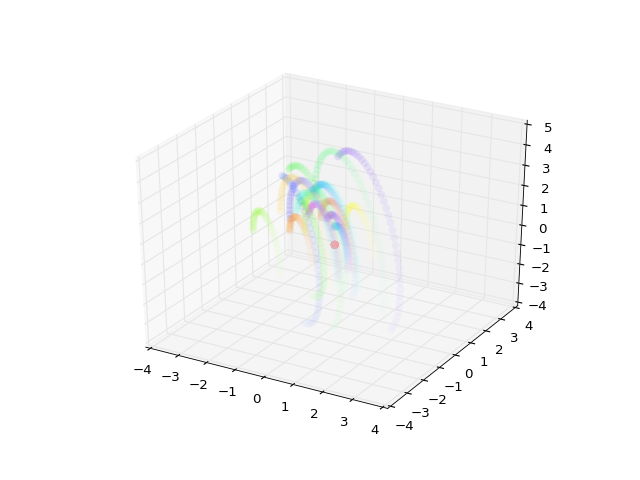

In [508]:
%matplotlib qt
a = PointCloud(3)
a.randomsetup(lines=5, points=20, size=1)
t = TransformationMatrix(3)
t.rotate_3d_about(a.points[0], numpy.pi/40,[0.72,0.72,0])
a.plot(*(t,)*40)


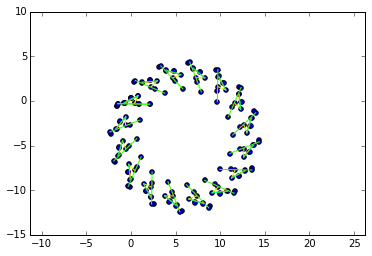

In [316]:
%matplotlib inline
a = PointCloud(dimensions = 2)
t = TransformationMatrix()

t.translate(2,2)
t.rotate_2d(-numpy.pi/8,[0,0])
a.randomsetup(lines=5, points=10)
a.plot()
for _ in range(16):
    a.transform(t)
    a.plot()

<IPython.core.display.Javascript object>


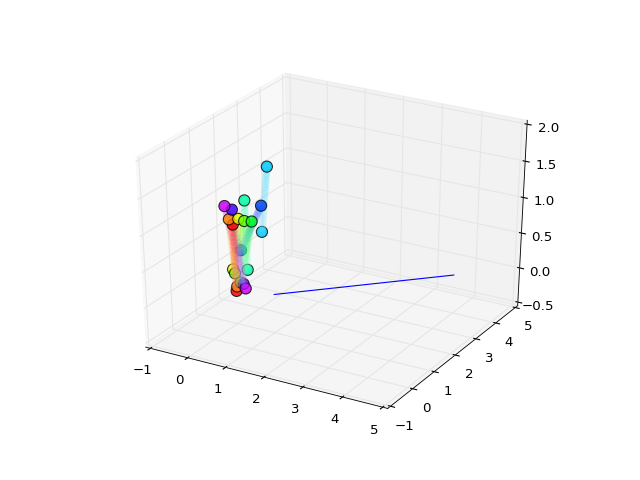

In [579]:
def pairwise_rmse(points1, points2):
    return numpy.sqrt((numpy.square(points1 - points2)).mean())

def solve_3d_transformation(operand, reference, subselection=None, test=True):
    if subselection is None:
        operand_points = numpy.mat(operand.points[:,:3])
        reference_points = numpy.mat(reference.points[:,:3])
    else:
        operand_points = numpy.mat(operand.points[subselection,:3])
        reference_points = numpy.mat(reference.points[subselection,:3])
    assert len(operand_points) == len(reference_points)

    n_points = operand_points.shape[0]

    operand_centroid = numpy.mean(operand_points, axis=0)
    reference_centroid = numpy.mean(reference_points, axis=0)
    
    # centre the points
    operand_centred   = operand_points - numpy.tile(operand_centroid, (n_points, 1))
    reference_centred   = reference_points - numpy.tile(reference_centroid, (n_points, 1))

    # dot is matrix multiplication for array
    covariance_matrix = numpy.transpose(operand_centred) * reference_centred

    unitary_matrix, diagonal_matrix, unitary_over_field = numpy.linalg.svd(covariance_matrix)

    rotation_matrix = unitary_over_field.T * unitary_matrix.T
    # special reflection case
    if numpy.linalg.det(rotation_matrix) < 0:
       unitary_over_field[2,:] *= -1
       rotation_matrix = unitary_over_field.T * unitary_matrix.T
    translation_vector = -rotation_matrix*operand_centroid.T + reference_centroid.T

    rotation_matrix = numpy.pad(
            rotation_matrix, 
            pad_width = ((0,1),(0,1)), 
            mode="constant", 
            constant_values=0)
    rotation_matrix[3,3] = 1


    translation_matrix = numpy.zeros((4,4))
    numpy.fill_diagonal(translation_matrix, 1)
    translation_matrix[:3,3:] = translation_vector
    

    transformation_matrix = TransformationMatrix(3)
    transformation_matrix.matrix = translation_matrix.dot(rotation_matrix)

    if test:
        operand_4d =numpy. pad(
            operand_points,
            pad_width= ((0,0),) * (1) + ((0,1),), 
            mode="constant", 
            constant_values=1
        )
        #transformed_operand = operand_4d.dot(transformation_matrix.matrix.T)[:,:3]
        transformed_operand = operand.clone()
        transformed_operand.transform(transformation_matrix)
        rmse = pairwise_rmse(transformed_operand.points[:,:3], reference.points[:,:3])
        #print(rmse)
        return transformation_matrix, rmse, transformed_operand
tm, rmse, tr = solve_3d_transformation(ap, bp)
#ap.plot()
#bp.plot()
sol = ap.clone()
sol.plot_3d_transform(tm, steps=20, references=[ap, bp])

0.183026634517


<IPython.core.display.Javascript object>


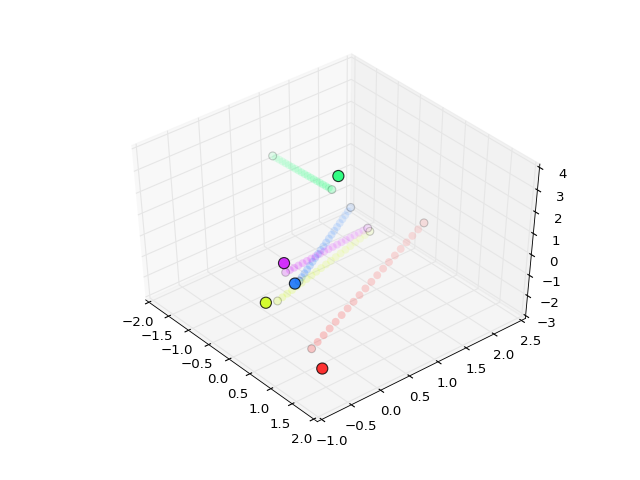

In [544]:
''''''
ref_points = PointCloud(3)
ref_points.randomsetup(lines=0, points=5)
t = TransformationMatrix(3)
t.randomise_3d()
t.randomise_3d()
t.randomise_3d()
op_points = ref_points.clone()
op_points.transform(t)
''''''
tm, rmse, aligned = solve_3d_transformation(op_points, ref_points)
print(rmse)
op_points.plot_3d_transform(tm, steps=20, references=[ref_points])


[ 0.60371279 -0.66139873  0.44506469  0.73423419]


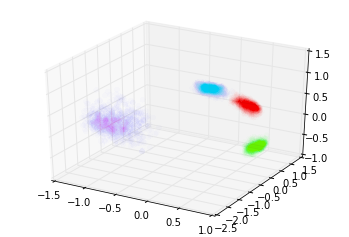

In [629]:
from random import shuffle

def bootstrap_solve_3d(op_points, ref_points, size=3, intensity=40):
    n_points = op_points.points.shape[0]
    point_indices = list(range(n_points))
    n_subsels = n_points/size
    subselections = []
    for _ in range(intensity):
        pass_ssels = [list() for _ in range(n_subsels)]
        shuffle(point_indices)
        for i, x in enumerate(point_indices):
            pass_ssels[i%n_subsels].append(x)
        subselections += pass_ssels
    solutions = []
    rmses = []
    for subsel in subselections:
        #print(subsel)
        tm, rmse,_ = solve_3d_transformation(op_points, ref_points, subselection=subsel)
        solutions.append({"rmse" : rmse, "tm" : tm})
        rmses.append(rmse)
    rmse_cutoff = numpy.mean(rmses)
    solutions = [solution["tm"].matrix for solution in solutions if solution["rmse"] < rmse_cutoff]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    hues = numpy.linspace(0,0.8,4)
    for solution in solutions:
        for point in [0,1,2]:
            cols = [hsv_to_rgb(h,1,1) for h in hues]
            ax.scatter(
                solution[0,:], 
                solution[1,:], 
                solution[2,:], 
                 lw = 0,
                alpha=0.005,
                c=cols,
                s=50
            )
    print(solution[2,:])
    return None, None, None
    
ref_points = PointCloud(3)
ref_points.randomsetup(lines=0, points=100)
t = TransformationMatrix(3)
t.randomise_3d()
t.randomise_3d()
t.randomise_3d()
op_points = ref_points.clone()
op_points.transform(t)
op_points.mutate()
tm, rmse, aligned = bootstrap_solve_3d(op_points, ref_points)

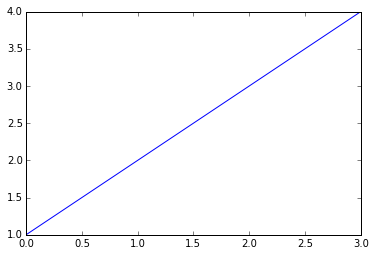

In [591]:
%matplotlib inline
plt.plot([1,2,3,4])

In [441]:
ap = PointCloud(3)
bp = PointCloud(3)

pa = numpy.array([[ 0.26832805,  0.57129996,  0.05275835],
 [ 0.14437605,  0.79728663,  0.0503873 ],
 [ 0.03560124,  0.81480421,  0.27551898],
 [ 0.26079327 , 0.53683492 , 0.30887791],
 [ 0.68142564 , 0.1024622 ,  0.32793634],
 [ 0.53706422 , 0.63448485 , 0.37119874],
 [ 0.91510412 , 0.6630108 ,  0.93860456],
 [ 0.49826643 , 0.43610394 , 0.68186992],
 [ 0.33901613 , 0.76119177 , 0.11922139],
 [ 0.28837246 , 0.92693572 , 0.01138285]])

pb = numpy.array([[ 0.57232678 , 0.01149324 , 1.13154136],
 [ 0.61665812, -0.21100935,  1.25388114],
 [ 0.86457814, -0.21766888 , 1.29013596],
 [ 0.80088173, 0.11991548 , 1.18491826],
 [ 0.63891594 , 0.68518925 , 1.04276649],
 [ 0.71350129 , 0.28620612 , 1.41827874],
 [ 1.0197748 ,  0.75158067 , 1.81236037],
 [ 1.01520482 , 0.48747756 , 1.34184818],
 [ 0.58342516, -0.0235825  , 1.34158791],
 [ 0.50396425 ,-0.1964217 ,  1.41559847]])
ap.add_points(pa)
bp.add_points(pb)

In [417]:
solve_3d_transformation(pa, pb)

(<__main__.TransformationMatrix instance at 0x7f44735b8a28>,
 0.9644847417792225,
 array([[-0.13147487, -0.33301216,  0.0174967 ],
        [-0.0707411 , -0.46474035,  0.01671037],
        [-0.01744383, -0.47495139,  0.09137269],
        [-0.12778299, -0.3129224 ,  0.10243579],
        [-0.33388364, -0.05972547,  0.1087563 ],
        [-0.26314971, -0.36984279,  0.12310378],
        [-0.44838098, -0.38647063,  0.31127737],
        [-0.24413964, -0.25420606,  0.22613429],
        [-0.16611048, -0.44370056,  0.0395384 ],
        [-0.14129619, -0.54031312,  0.00377499]]))